# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Run Fit                    |                                               |
| 6. Save project               ||
| 7. Verify fit results         ||
| 7.1 If not OK revise parameners and refit (go to 2.4)||
| 7.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


In [1]:
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

project_name = 'FeS2_larch.prj'


fes2_prj = read_athena(project_name)

group_keys = list(fes2_prj._athena_groups.keys())

group_names = {}

for group_key in group_keys:
    group_names[group_key] = group_key

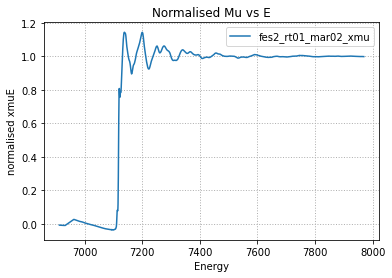

In [2]:
# required larch modules
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf

%matplotlib inline
import matplotlib.pyplot as plt

 #######################################################
# |         Athena recalculates everything so we      | #
# |      need to create a function that calculates    | #
# V               all for each new group              V #
 #######################################################

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)    
    # calculate pre-edge and post edge and add them to group
    pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group


 #######################################################
# |       The code for plotting Nmu vs E repeats      | #
# |   so it is useful to have a plotting function     | #
# V            to reduce duplicated code              V #
 #######################################################
# plot mu vs flat normalised mu for selected groups
def plot_NxmuE_E_athena_prj(athena_project, group_keys, group_names,
                            title = "Normalised Mu vs E", xlimits = None,
                            ylimits = None):    
    # plot mu vs flat normalised mu for selected groups
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        # recalculate normalisation
        calc_with_defaults(gr_0)
        plt.plot(gr_0.energy, gr_0.flat, label=group_names[group_key])

    # set plot format
    plt.xlabel("Energy")
    plt.ylabel("normalised xmuE" )
    plt.title(title)
    plt.grid(linestyle=':', linewidth=1) #show and format grid
    if xlimits != None:
        plt.xlim(xlimits[0],xlimits[1])
    if ylimits != None:
        plt.ylim(ylimits[0],ylimits[1])
    plt.legend()
    return plt

# plot normalised mu on energy
# plot mu vs flat normalised mu for selected groups
plt = plot_NxmuE_E_athena_prj(fes2_prj, group_keys, group_names)
plt.show()
# need to read parameters for pre-edge and background the calculating with  
# defaul values undoes the work of previous step (setting pre-edge limits).

In [3]:
# larch does not include a means for running atoms
# need to run atoms to get input for feff and then
# calculate paths

# currently the fastest option is to run Artemis to
# obtain the input (.inp) file for feff from a '.cif'
# or '.inp' file

# get subprocess to run perl script
import subprocess

# get the input file
var = "FeS2.inp"

retcode = subprocess.call(["perl", "feff_inp.pl", var])
if retcode == 0:
    print("Passed!")
else:
    print("Failed!")
    
# run feff and get the paths
from larch.xafs.feffrunner import feff6l
#feff6l(folder='.', feffinp='feff.inp', verbose=True)
feff6l(folder = './fes2_feff',feffinp='fes2_feff.inp' )

Passed!
 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep and heap limits   0.0000000   0.0000000
 : Preparing neigh

<External Feff Group: ./fes2_feff\fes2_feff.inp>

In [4]:
import subprocess
var = "FeS2.inp"
retcode = subprocess.call(["perl", "feff_inp.pl", var])
if retcode == 0:
    print("Passed!")
else:
    print("Failed!")

Passed!


In [5]:
import subprocess
var = "FeS2_cry.inp"
spr = subprocess.run(["perl", "./feff_inp.pl", var])
spr

CompletedProcess(args=['perl', './feff_inp.pl', 'FeS2_cry.inp'], returncode=0)

In [6]:
import os, string
my_cmd = "dir"
my_cmd_output = os.popen(my_cmd)
for line in my_cmd_output:
  print(line.rstrip())
print("Done.") 

 Volume in drive C has no label.
 Volume Serial Number is CAE1-D2E5

 Directory of C:\harwell\XAS-Workflow-Demo\larch_workflow

17/02/2021  22:52    <DIR>          .
17/02/2021  22:52    <DIR>          ..
15/02/2021  17:22    <DIR>          .ipynb_checkpoints
17/02/2021  21:55             1,109 feff_inp.pl
26/01/2021  18:03               403 FeS2.inp
26/01/2021  18:03               403 FeS2_cry.inp
17/02/2021  22:52    <DIR>          fes2_cry_feff
17/02/2021  22:52    <DIR>          fes2_feff
15/02/2021  18:11             5,369 fes2_larch.prj
26/01/2021  18:05            17,050 fes2_rt01_mar02.xmu
15/02/2021  18:11            97,265 larch_task01.ipynb
17/02/2021  22:51            41,776 larch_task02.ipynb
               7 File(s)        163,375 bytes
               5 Dir(s)  38,996,119,552 bytes free
Done.


In [7]:
os.getcwd()

'C:\\harwell\\XAS-Workflow-Demo\\larch_workflow'